In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os

import numpy as np
import torch
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import random

from handwriting_recognition.label_converter import LabelConverter
from handwriting_recognition.model.model import HandwritingRecognitionModel
from handwriting_recognition.modelling_utils import get_image_model
from handwriting_recognition.utils import TrainingConfig, get_dataset_folder_path
from handwriting_recognition.dataset import HandWritingDataset
from pathlib import Path
from handwriting_recognition.modelling_utils import get_device
from handwriting_recognition.eval import cer, wer

torch.backends.cudnn.benchmark = True

/home/faraz/.cache/pypoetry/virtualenvs/handwriting-recognition-05HTZ8rb-py3.11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [18]:
from ray.tune import ExperimentAnalysis

EXPERIMENT_ANALYSIS_PATH = "~/Documents/train_handwriting_recognition_2024-05-26_11-50-45/experiment_state-2024-05-26_11-50-45.json"

experiment_results = ExperimentAnalysis(EXPERIMENT_ANALYSIS_PATH, default_metric="val_loss", default_mode="min")

In [17]:
experiment_results.best_config

{'seed': 1234,
 'batch_size': 32,
 'batches_per_epoch': 10000,
 'max_epochs': 100,
 'early_stopping_threshold': 5,
 'optim_config': {'optim_type': 'adam',
  'learning_rate': 0.0008026030044184882,
  'momentum': 0.0079579154064284,
  'weight_decay': 0.0001,
  'beta1': 0.9350027413928015,
  'beta2': 0.811482494869981},
 'scheduler_config': {'scheduler_type': 'cosine',
  'params': {'T_max': 85, 'eta_min': 0.0002981600259808856}},
 'feature_extractor_config': {'model_name': 'resnet34', 'input_size': 224},
 'lstm_hidden_size': 128,
 'max_text_length': None,
 'num_classes': None,
 'attention_hidden_size': 512}

In [24]:
checkpoint_path = Path(experiment_results.best_checkpoint.path)

In [27]:
MODEL_PATH = checkpoint_path / "checkpoint.pt"

In [132]:
MODEL_PATH

PosixPath('/home/faraz/Documents/train_handwriting_recognition_2024-05-26_11-50-45/train_handwriting_recognition_5e650_00045_45_attention_hidden_size=512,batch_size=32,batches_per_epoch=10000,lstm_hidden_size=128,_2024-05-26_11-50-46/checkpoint_000035/checkpoint.pt')

In [28]:
saved_model = torch.load(MODEL_PATH)

In [30]:
config = saved_model['config']

In [31]:
data_train = HandWritingDataset(
    data_path=get_dataset_folder_path() / "pre_processed" / "train.csv",
    img_size=config["feature_extractor_config"]["input_size"],
)

data_val = HandWritingDataset(
    data_path=get_dataset_folder_path() / "pre_processed" / "validation.csv",
    img_size=config["feature_extractor_config"]["input_size"],
)

data_test = HandWritingDataset(
    data_path=get_dataset_folder_path() / "pre_processed" / "test.csv",
    img_size=config["feature_extractor_config"]["input_size"],
)

In [32]:
converter = LabelConverter(
    character_set=saved_model["character_set"], max_text_length=saved_model["max_text_length"]
)

In [33]:
model = HandwritingRecognitionModel(
    image_feature_extractor_name=config["feature_extractor_config"]["model_name"],
    num_classes=len(converter.characters),
    max_text_length=data_train.max_length,
    lstm_hidden_size=config["lstm_hidden_size"],
    attention_hidden_size=config["attention_hidden_size"],
)

model.load_state_dict(saved_model["state"])

<All keys matched successfully>

In [34]:
model = model.to(get_device())
model = model.eval()

In [35]:
BATCH_SIZE = config['batch_size']

In [36]:
train_loader = DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
)

val_loader = DataLoader(
    data_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
)

test_loader = DataLoader(
    data_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
)

In [37]:
images, labels = next(iter(train_loader))

In [38]:
images.shape

torch.Size([32, 1, 224, 224])

In [39]:
text, length = converter.encode(labels)
text = text.to(device=get_device())
images = images.to(device=get_device())

In [40]:
preds = model(x=images, y=text[:, :-1], is_train=False)
target = text[:, 1:]

In [41]:
predicted_classes = preds.argmax(dim=-1)

In [42]:
pred_decoded = converter.decode(predicted_classes, length)
pred_decoded[:3]

['BALTHAZAR[s][s][s][s][s][s][s][s][s][s][s]',
 'SIMON[s][s][s]ON[s]ON[s][s][s][s]ON[s]',
 'BENES[s][s][s][s][s][s][s][s][s][s][s][s][s][s][s]']

In [43]:
target_decoded = converter.decode(target, length)
target_decoded[:3]

['BALTHAZAR[s][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO]',
 'SIMON[s][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO]',
 'BENES[s][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO][GO]']

In [45]:
from handwriting_recognition.train import _evaluate
loss_function = CrossEntropyLoss(ignore_index=0).to(get_device())

In [53]:
train_loss, train_character_error_rate, train_word_error_rate, all_train_preds, all_train_ground_truths = _evaluate(
    epoch=saved_model['epoch'],
    model=model,
    data_loader=train_loader,
    converter=converter,
    loss_function=loss_function
)

Validating Epoch: 36: 100% 9963/9963 [05:14<00:00, 31.73it/s]


In [54]:
train_character_error_rate

0.05536695569753647

In [55]:
train_word_error_rate

0.2224564403295517

In [46]:
validation_loss, val_character_error_rate, val_word_error_rate, all_val_preds, all_val_ground_truths = _evaluate(
    epoch=saved_model['epoch'],
    model=model,
    data_loader=val_loader,
    converter=converter,
    loss_function=loss_function
)

Validating Epoch: 36: 100% 1247/1247 [00:39<00:00, 31.62it/s]


In [47]:
val_character_error_rate

0.05962999537587166

In [48]:
val_word_error_rate

0.23563218116760254

In [49]:
test_loss, test_character_error_rate, test_word_error_rate, all_test_preds, all_test_ground_truths = _evaluate(
    epoch=saved_model['epoch'],
    model=model,
    data_loader=test_loader,
    converter=converter,
    loss_function=loss_function
)

Validating Epoch: 36: 100% 1246/1246 [00:45<00:00, 27.35it/s]


In [50]:
test_character_error_rate

0.05978250503540039

In [51]:
test_word_error_rate

0.23601119220256805

In [56]:
import pickle

with open("updated_test_ground_truths.pkl", 'wb') as f:
    pickle.dump(all_test_ground_truths, f)

with open("updated_test_preds.pkl", 'wb') as f:
    pickle.dump(all_test_preds, f)

with open("updated_val_ground_truths.pkl", 'wb') as f:
    pickle.dump(all_val_ground_truths, f)
    
with open("updated_val_preds.pkl", 'wb') as f:
    pickle.dump(all_val_preds, f)

with open("updated_train_ground_truths.pkl", 'wb') as f:
    pickle.dump(all_train_ground_truths, f)
    
with open("updated_train_preds.pkl", 'wb') as f:
    pickle.dump(all_train_preds, f)

In [91]:
final_res_path = checkpoint_path.parent / max([x for x in os.listdir(checkpoint_path.parent) if "checkpoint_" in x]) / "checkpoint.pt"
final_res = torch.load(final_res_path)

all_train_losses = final_res['all_train_loss']
all_val_losses = final_res['all_val_loss']

assert len(all_train_losses) == len(all_val_losses)

epochs = [i + 1 for i in range(len(all_train_losses))]

In [92]:
import matplotlib.pyplot as plt

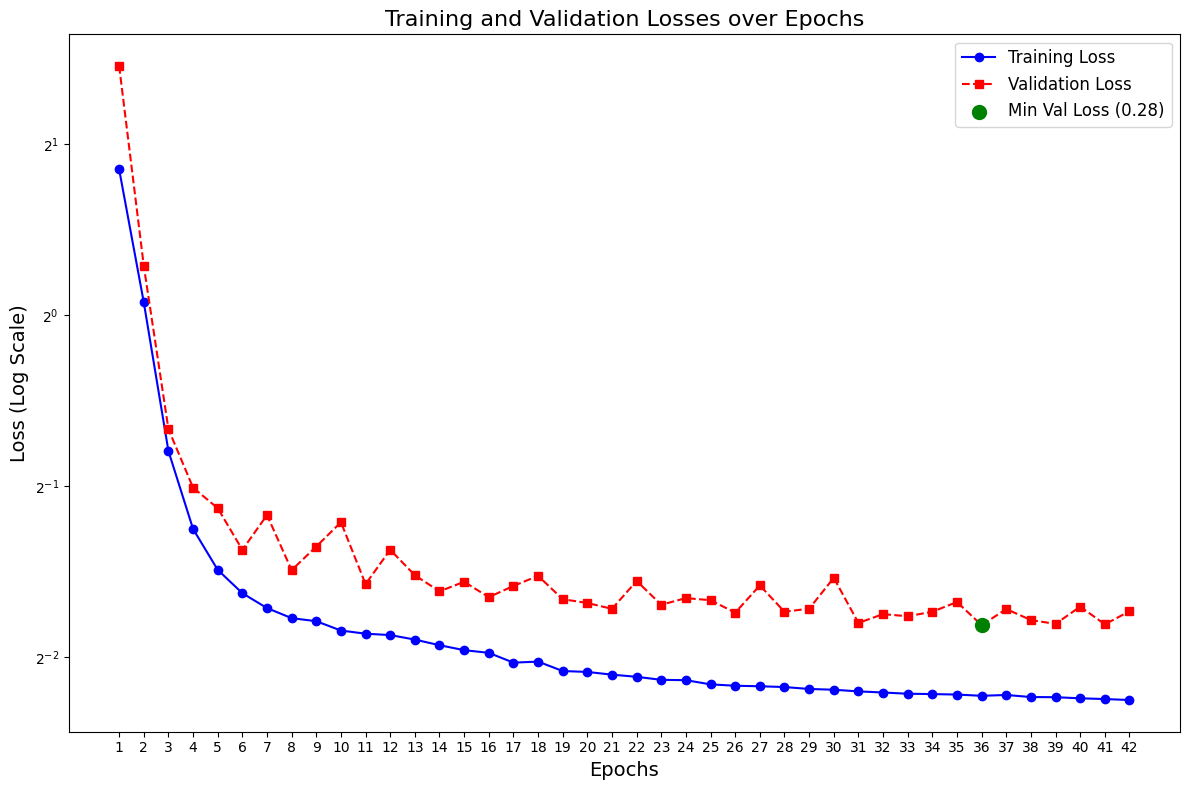

In [128]:
plt.figure(figsize=(12, 8))
plt.plot(epochs, all_train_losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.plot(epochs, all_val_losses, marker='s', linestyle='--', color='r', label="Validation Loss")

min_val_loss = min(all_val_losses)
min_val_loss_epoch = epochs[all_val_losses.index(min_val_loss)]

plt.scatter(min_val_loss_epoch, min_val_loss, color='g', s=100, zorder=5, label=f"Min Val Loss ({min_val_loss:.2f})")

plt.title("Training and Validation Losses over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss (Log Scale)", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(epochs) 
plt.yscale("log", base=2)

plt.tight_layout()
plt.show()

In [129]:
all_cer = final_res['all_cer']
all_wer = final_res['all_wer']

assert len(all_cer) == len(all_wer) == len(epochs)

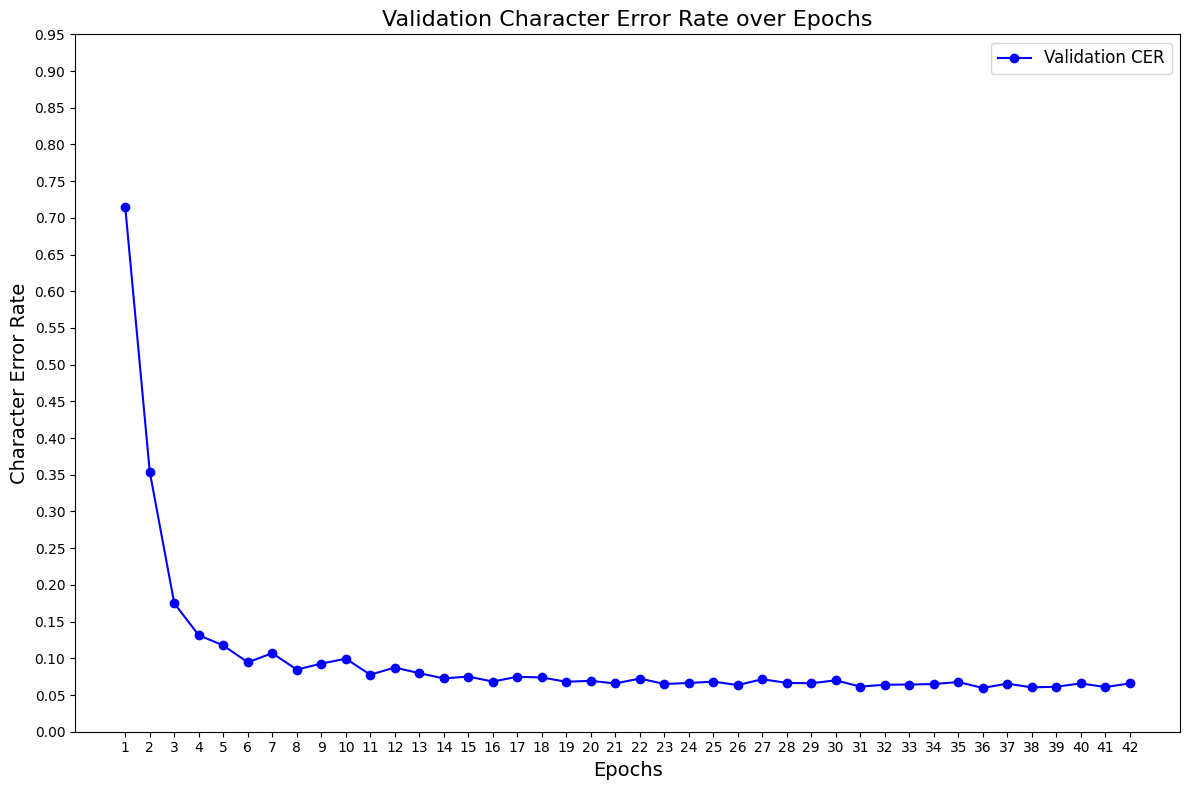

In [130]:
plt.figure(figsize=(12, 8))
plt.plot(epochs, all_cer, marker='o', linestyle='-', color='b', label="Validation CER")

plt.title("Validation Character Error Rate over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Character Error Rate", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(epochs) 
plt.yticks(np.linspace(0, 1, num=20, endpoint=False))

plt.tight_layout()
plt.show()

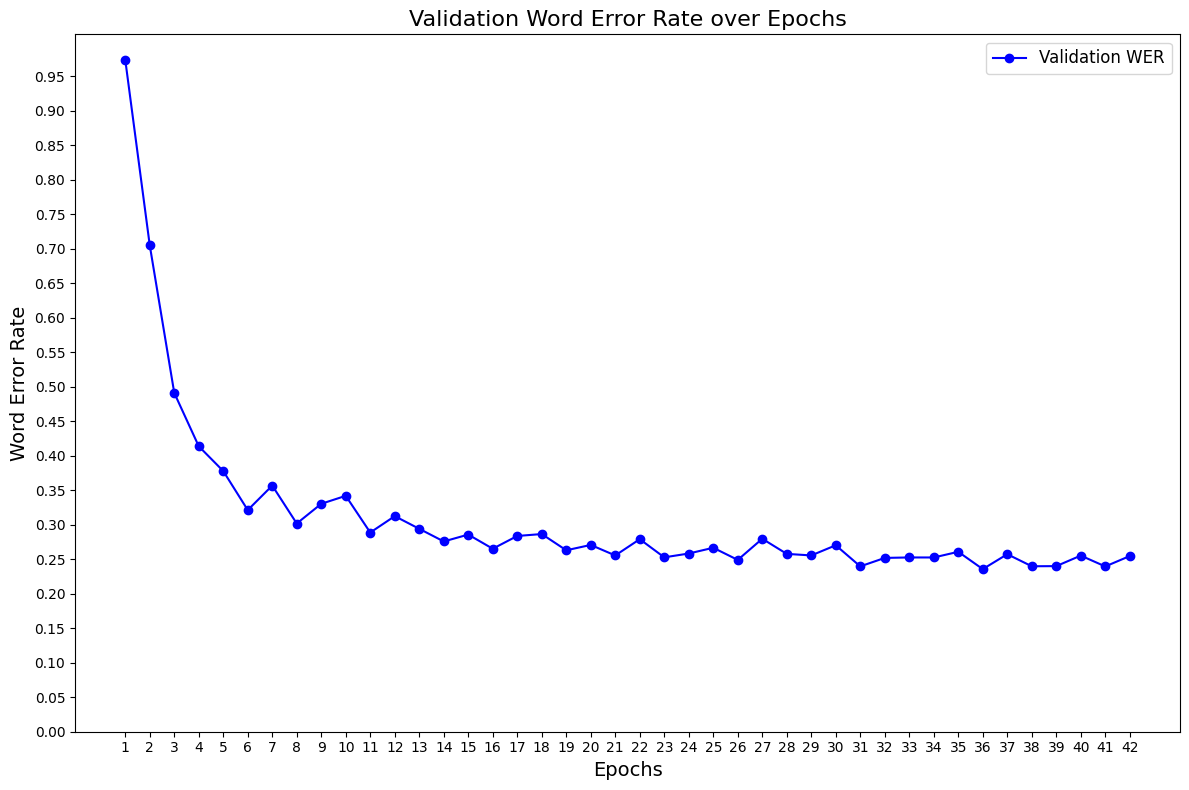

In [131]:
plt.figure(figsize=(12, 8))
plt.plot(epochs, all_wer, marker='o', linestyle='-', color='b', label="Validation WER")

plt.title("Validation Word Error Rate over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Word Error Rate", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(epochs) 
plt.yticks(np.linspace(0, 1, num=20, endpoint=False))
plt.tight_layout()
plt.show()